![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 15 - Variational Auto-encoder </center>
### <center> Vanilla VAE </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/15_VAE/MainVAE.ipynb)

In [1]:
#-- Wide screen :
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

import torch
import torch.nn          as nn
import torch.optim       as optim
import torchinfo

For Colab users:

In [4]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/15_VAE/DeepLearningFramework ./DeepLearningFramework

#### Load MNIST data:

In [5]:
import torchvision.transforms as transforms
import torchvision

dataPath  = r'../../data/'
oTrainSet = torchvision.datasets.MNIST(root=dataPath, train=True,  transform=transforms.ToTensor(), download=True)
oTestSet  = torchvision.datasets.MNIST(root=dataPath, train=False, transform=transforms.ToTensor(), download=True)

In [6]:
batchSize = 128
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize,   num_workers=2)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, num_workers=2)

mX, _     = next(iter(oTrainDL))
mX.shape

torch.Size([128, 1, 28, 28])

#### VAE encoder:
For each input image $\boldsymbol{x}_i\in\mathbb{R}^D$,  
the output is the latent space distribution:
$$q_{\underline{Z}|\underline{X}}\left(\boldsymbol{z},\boldsymbol{x}_{i}\right)=\mathcal{N}_{d}\left(\boldsymbol{z};\boldsymbol{\mu}\left(\boldsymbol{x}_{i}\right),\boldsymbol{\Sigma}\left(\boldsymbol{x}_{i}\right)\right)$$

In practice, the encoder outputs the log of the (diagonal) covariance.

In [7]:
class Encoder(nn.Module):
    def __init__(self, D):
        super(Encoder, self).__init__()
        self.oEncoder = nn.Sequential(
            nn.Identity(),
            nn.Conv2d(1,  8,   kernel_size=5, bias=False),           nn.BatchNorm2d(8 ), nn.LeakyReLU(), 
            nn.Conv2d(8,  16,  kernel_size=5, bias=False),           nn.BatchNorm2d(16), nn.LeakyReLU(),
            nn.Conv2d(16, 32,  kernel_size=5, bias=False, stride=2), nn.BatchNorm2d(32), nn.LeakyReLU(),
            nn.Conv2d(32, 64,  kernel_size=5, bias=False),           nn.BatchNorm2d(64), nn.LeakyReLU(),
            nn.Conv2d(64, 2*D, kernel_size=4), 
            nn.Flatten()
        )
        
    def forward(self, mX):
        mOut      = self.oEncoder(mX)
        mμ, mLogΣ = mOut.chunk(2, dim=1)
            
        return mμ, mLogΣ
#=============================================================#
#=============================================================#
D = 2
print(torchinfo.summary(Encoder(D), (128, 1, 28, 28)))
mμ,       mLogΣ = Encoder(D)(mX)
mμ.shape, mLogΣ.shape

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  --                        --
├─Sequential: 1-1                        [128, 4]                  --
│    └─Identity: 2-1                     [128, 1, 28, 28]          --
│    └─Conv2d: 2-2                       [128, 8, 24, 24]          200
│    └─BatchNorm2d: 2-3                  [128, 8, 24, 24]          16
│    └─LeakyReLU: 2-4                    [128, 8, 24, 24]          --
│    └─Conv2d: 2-5                       [128, 16, 20, 20]         3,200
│    └─BatchNorm2d: 2-6                  [128, 16, 20, 20]         32
│    └─LeakyReLU: 2-7                    [128, 16, 20, 20]         --
│    └─Conv2d: 2-8                       [128, 32, 8, 8]           12,800
│    └─BatchNorm2d: 2-9                  [128, 32, 8, 8]           64
│    └─LeakyReLU: 2-10                   [128, 32, 8, 8]           --
│    └─Conv2d: 2-11                      [128, 64, 4, 4]           51,200
│  

(torch.Size([128, 2]), torch.Size([128, 2]))

#### VAE decoder:
Similar to a regular AE decoder.  
For each instance in the latent space, the decoder outputs an image.

In [8]:
from DeepLearningFramework.Layers import Reshape

def Decoder(D):
    oDecoder = nn.Sequential(
        nn.Identity(),
        Reshape((D, 1, 1)),
        nn.Upsample(scale_factor=2), nn.Conv2d(D,  64, kernel_size=3, padding=1, bias=False), nn.BatchNorm2d(64), nn.LeakyReLU(), 
        nn.Upsample(scale_factor=2), nn.Conv2d(64, 32, kernel_size=3, padding=1, bias=False), nn.BatchNorm2d(32), nn.LeakyReLU(), 
        nn.Upsample(scale_factor=2), nn.Conv2d(32, 16, kernel_size=3, padding=1, bias=False), nn.BatchNorm2d(16), nn.LeakyReLU(), 
        nn.Upsample(scale_factor=2), nn.Conv2d(16, 8,  kernel_size=3, padding=1, bias=False), nn.BatchNorm2d(8 ), nn.LeakyReLU(), 
        nn.Upsample(scale_factor=2), nn.Conv2d(8,  4,  kernel_size=3, padding=1, bias=True ),                     nn.LeakyReLU(), 
                                     nn.Conv2d(4,  1,  kernel_size=5, padding=0, bias=True ),
    )

    return oDecoder

#=============================================================#
#=============================================================#
D = 2
torchinfo.summary(Decoder(D), (128, D))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Identity: 1-1                          [128, 2]                  --
├─Reshape: 1-2                           [128, 2, 1, 1]            --
├─Upsample: 1-3                          [128, 2, 2, 2]            --
├─Conv2d: 1-4                            [128, 64, 2, 2]           1,152
├─BatchNorm2d: 1-5                       [128, 64, 2, 2]           128
├─LeakyReLU: 1-6                         [128, 64, 2, 2]           --
├─Upsample: 1-7                          [128, 64, 4, 4]           --
├─Conv2d: 1-8                            [128, 32, 4, 4]           18,432
├─BatchNorm2d: 1-9                       [128, 32, 4, 4]           64
├─LeakyReLU: 1-10                        [128, 32, 4, 4]           --
├─Upsample: 1-11                         [128, 32, 8, 8]           --
├─Conv2d: 1-12                           [128, 16, 8, 8]           4,608
├─Ba

### VAE

In [9]:
class VAE(nn.Module):
    def __init__(self, D):
        super(VAE, self).__init__()

        self.oEncoder = Encoder(D)
        self.oDecoder = Decoder(D)

    def forward(self, mX):
        #-- Encode:
        mμ, mLogΣ = self.oEncoder(mX)

        #-- Sample:
        if self.training == True:
            mϵ = torch.randn_like(mμ)
            vσ = torch.exp(.5 * mLogΣ)
            mZ = vσ * mϵ + mμ
        else:
            mZ = mμ

        #-- Decode:
        mHatX = self.oDecoder(mZ)

        return mHatX, mμ, mLogΣ

#=============================================================#
#=============================================================#
D = 2
print(torchinfo.summary(VAE(D), mX.shape))

mHatX,       mμ,       mLogΣ = VAE(D)(mX)
mHatX.shape, mμ.shape, mLogΣ.shape

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      --                        --
├─Encoder: 1-1                           [128, 2]                  --
│    └─Sequential: 2-1                   [128, 4]                  --
│    │    └─Identity: 3-1                [128, 1, 28, 28]          --
│    │    └─Conv2d: 3-2                  [128, 8, 24, 24]          200
│    │    └─BatchNorm2d: 3-3             [128, 8, 24, 24]          16
│    │    └─LeakyReLU: 3-4               [128, 8, 24, 24]          --
│    │    └─Conv2d: 3-5                  [128, 16, 20, 20]         3,200
│    │    └─BatchNorm2d: 3-6             [128, 16, 20, 20]         32
│    │    └─LeakyReLU: 3-7               [128, 16, 20, 20]         --
│    │    └─Conv2d: 3-8                  [128, 32, 8, 8]           12,800
│    │    └─BatchNorm2d: 3-9             [128, 32, 8, 8]           64
│    │    └─LeakyReLU: 3-10              [128, 32, 8, 8]           --
│    │ 

(torch.Size([128, 1, 28, 28]), torch.Size([128, 2]), torch.Size([128, 2]))

### VAE loss:

$$L\left(\theta,\psi\right)=\frac{1}{N}\sum_{i=1}^{N}\left\Vert \boldsymbol{x}_{i}-\mathrm{D}_{\theta}\left(\boldsymbol{z}_{i}\right)\right\Vert _{2}^{2}+\beta D_{\mathrm{KL}}\left(\mathcal{N}\left(\boldsymbol{\mu}\left(\boldsymbol{x}_{i}\right),\boldsymbol{\Sigma}\left(\boldsymbol{x}_{i}\right)\right)||\mathcal{N}\left(\boldsymbol{0},\boldsymbol{I}\right)\right)$$
where:
$$D_{\mathrm{KL}}\left(\mathcal{N}_{d}\left(\boldsymbol{\mu},\text{diag}\left(\boldsymbol{\sigma}\right)\right)||\mathcal{N}_{d}\left(\boldsymbol{0},\boldsymbol{I}\right)\right)=\frac{1}{2}\sum_{i=1}^{d}\left(\sigma_{i}^{2}+\mu_{i}^{2}-1-\log\left(\sigma_{i}^{2}\right)\right)$$

In [10]:
class VAELoss():
    def __init__(self, β):
        self.β = β
    
    def __call__(self, mHatX, mμ, mLogVar, mX):
        MSE = nn.MSELoss(reduction='sum')(mHatX, mX)
        KLD = 0.5 * torch.sum(mμ**2 + mLogVar.exp() - 1 - mLogVar)
        N   = mX.shape[0]
    
        return (MSE + self.β * KLD) / N

#### Epoch:

In [11]:
def Epoch(oModel, oDataDL, Loss, Metric, oOptim=None, oScheduler=None, bTrain=True):

    epochLoss   = 0
    epochMetric = 0
    count       = 0
    nIter       = len(oDataDL)
    vLR         = np.full(nIter, np.nan)
    DEVICE      = next(oModel.parameters()).device #-- CPU\GPU

    oModel.train(bTrain) #-- train or test

    #-- Iterate over the mini-batches:
    for ii, (mX, _) in enumerate(oDataDL):
        #-- Move to device (CPU\GPU):
        mX = mX.to(DEVICE)

        #-- Forward:
        if bTrain == True:
            mHatX, mμ, mLogΣ = oModel(mX)
            loss             = Loss  (mHatX, mμ, mLogΣ, mX)
        else:
            with torch.no_grad():
                mHatX, mμ, mLogΣ = oModel(mX)
                loss             = Loss  (mHatX, mμ, mLogΣ, mX)

        #-- Backward:
        if bTrain == True:
            oOptim.zero_grad() #-- set gradients to zeros
            loss.backward()    #-- backward
            oOptim.step()      #-- update parameters
            if oScheduler is not None:
                vLR[ii] = oScheduler.get_last_lr()[0]
                oScheduler.step() #-- update learning rate

        with torch.no_grad():
            Nb           = mX.shape[0]
            count       += Nb
            epochLoss   += Nb * loss.item()
            epochMetric += Nb * Metric(mHatX, mX)
        print(f'\r{"Train" if bTrain else "Val"} - Iteration: {ii:3d} ({nIter}): loss = {loss:2.6f}', end='')

    print('', end='\r')
    epochLoss   /= count
    epochMetric /= count

    return epochLoss, epochMetric, vLR

In [12]:
from torch.optim.lr_scheduler       import OneCycleLR
from DeepLearningFramework.Training import TrainModel
from DeepLearningFramework.Metric   import R2Score

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
Metric = R2Score

β      = 1
Loss   = VAELoss(β)

#### Train the model:

In [13]:
D          = 2
nEpochs    = 25
nIter      = nEpochs * len(oTrainDL)

oModel     = VAE       (D).to(DEVICE)
oOptim     = optim.Adam(oModel.parameters(), lr=0, betas=(0.9, 0.99))
oScheduler = OneCycleLR(oOptim, max_lr=1e-3, total_steps=nIter)
lHistory   = TrainModel(oModel, oTrainDL, oTestDL, Loss, Metric, nEpochs, oOptim, oScheduler, Epoch=Epoch, sModelName='VAE1');

------------------------------------------------------------------------------------------------------------------------
Epoch 000: | Train loss: 85.070 | Val loss: 49.276 | Train Metric: -0.126 | Val Metric:  0.376 | epoch time:  5.477 | <-- Checkpoint!
Epoch 001: | Train loss: 47.295 | Val loss: 43.630 | Train Metric:  0.403 | Val Metric:  0.462 | epoch time:  5.229 | <-- Checkpoint!
Epoch 002: | Train loss: 43.347 | Val loss: 41.316 | Train Metric:  0.466 | Val Metric:  0.500 | epoch time:  5.284 | <-- Checkpoint!
Epoch 003: | Train loss: 41.897 | Val loss: 39.789 | Train Metric:  0.490 | Val Metric:  0.522 | epoch time:  5.272 | <-- Checkpoint!
Epoch 004: | Train loss: 40.803 | Val loss: 39.527 | Train Metric:  0.508 | Val Metric:  0.530 | epoch time:  5.213 | <-- Checkpoint!
Epoch 005: | Train loss: 40.082 | Val loss: 38.745 | Train Metric:  0.520 | Val Metric:  0.541 | epoch time:  5.128 | <-- Checkpoint!
Epoch 006: | Train loss: 39.548 | Val loss: 39.353 | Train Metric:  0.528 |

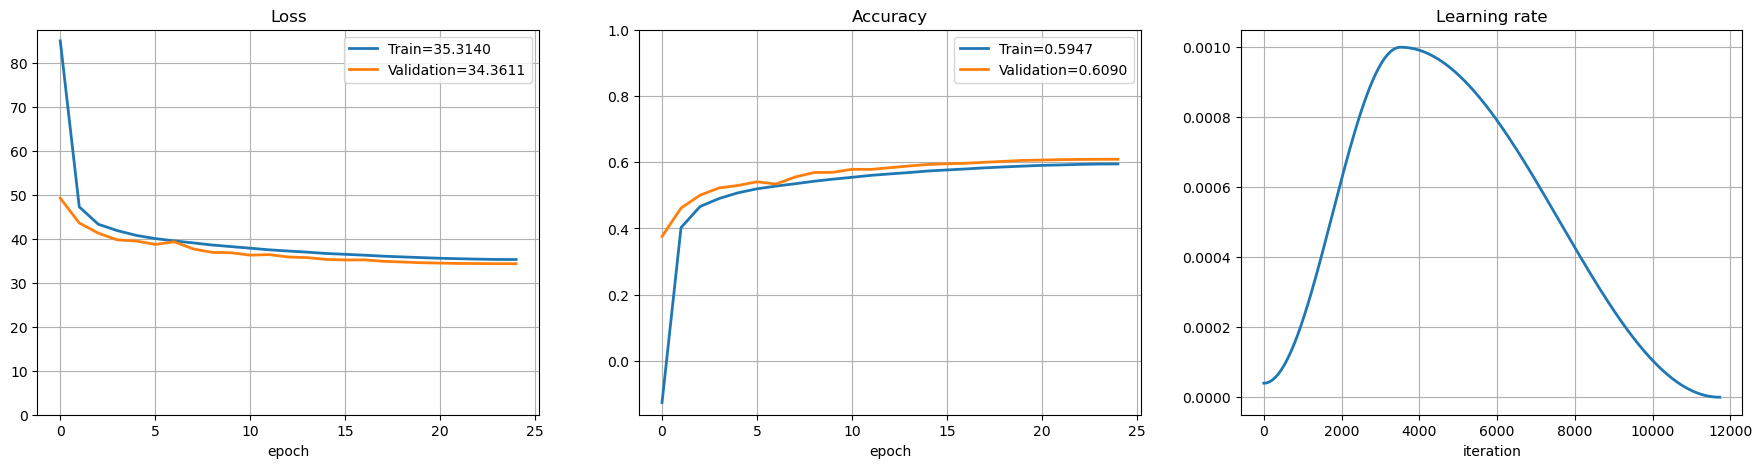

In [14]:
from DeepLearningFramework.Auxiliary import PlotHistory

PlotHistory(lHistory)
plt.show   ()

In [15]:
#-- Run this to load a trained model:
# oModel = VAE(D).to(DEVICE)
# oModel.load_state_dict(torch.load('VAE1.pt'))
# oModel.train(False);

#### Test reconstruction:

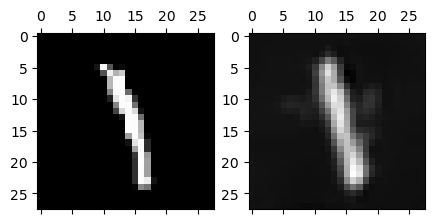

In [16]:
idx   = np.random.randint(len(oTestSet))
mX, _ = oTestSet[idx]
# mX    = torch.rand_like(mX)
with torch.no_grad():
    mHatX = oModel(mX[None,...].to(DEVICE))[0][0]

_, ax = plt.subplots(1, 2, figsize=(5, 3))
ax[0].matshow(mX   [0],       cmap='gray')
ax[1].matshow(mHatX[0].cpu(), cmap='gray')
plt.show()

### Encode the train\test data:

In [17]:
K         = 2000
oTrainDL2 = torch.utils.data.DataLoader(oTrainSet, batch_size=K)
oTestDL2  = torch.utils.data.DataLoader(oTestSet,  batch_size=K)

mTrainX, vTrainY = next(iter(oTrainDL2))
mTestX,  vTestY  = next(iter(oTestDL2))
oModel.to(DEVICE)

oEncoder = oModel.oEncoder
with torch.no_grad():
    mTrainZ  = oEncoder(mTrainX.to(DEVICE))[0].cpu().numpy()
    mTestZ   = oEncoder(mTestX .to(DEVICE))[0].cpu().numpy()

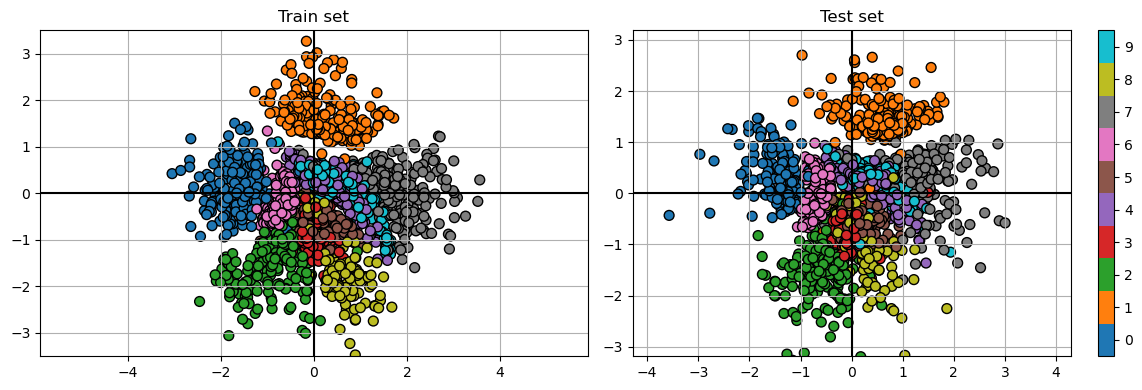

In [18]:
def PlotScatter(mZ, vY, sTitle, ax):
    h = ax.scatter(*mZ.T,  s=50, c=vY, edgecolor='k', cmap='tab10', vmin=-.5, vmax=9.5)
    ax.set_title  (sTitle)
    ax.axis       ('equal')
    ax.axis       ([-3.5, 3.5, -3.5, 3.5])
    ax.axvline    (c='k')
    ax.axhline    (c='k')
    ax.grid       ()
    
    return h

_, ax = plt.subplots(1, 2, figsize=(12, 4))
h = PlotScatter(mTrainZ, vTrainY, 'Train set', ax[0])
h = PlotScatter(mTestZ,  vTestY,  'Test set',  ax[1])

plt.colorbar    (h, ticks=range(10))
plt.tight_layout()
plt.show        ()

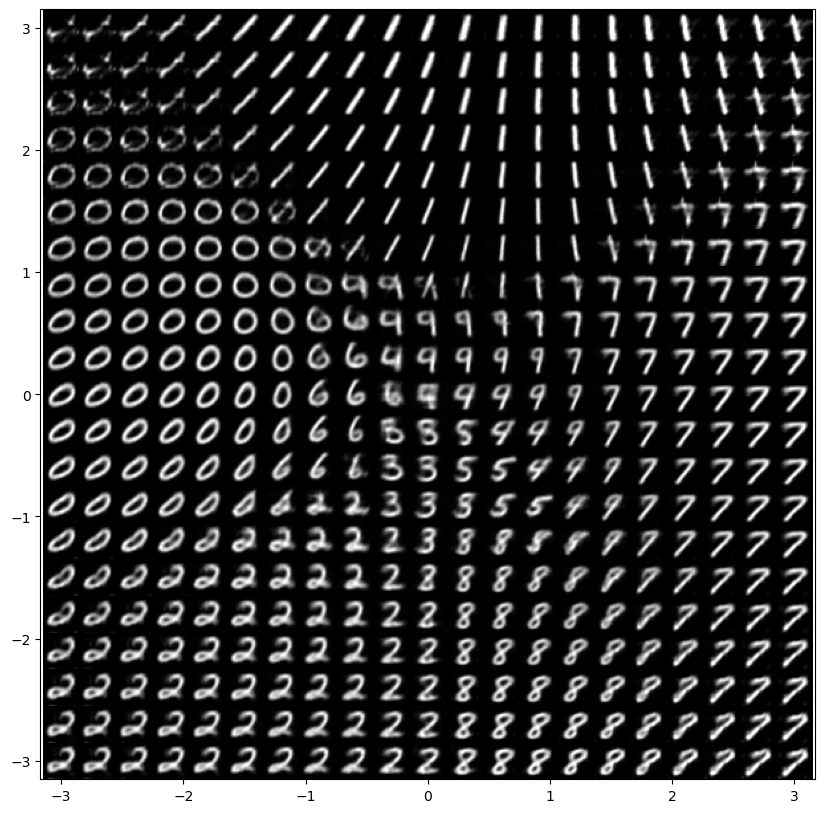

In [19]:
oDecoder   = oModel.oDecoder
v1         = torch.linspace(-3, 3, 21)
v2         = torch.linspace(-3, 3, 21)
mZZ1, mZZ2 = torch.meshgrid(v1, v2)
mZZ        = torch.stack   ([mZZ1.ravel(), mZZ2.ravel()], dim=1)

with torch.no_grad():
    mNewX = oDecoder(mZZ.to(DEVICE)).cpu().squeeze()

M    = mZZ.shape[0]
size = .15
fig  = plt.figure(figsize=(10, 10))
for ii in range(M):
    x0  = mZZ[ii,0] - size
    x1  = mZZ[ii,0] + size
    y0  = mZZ[ii,1] - size
    y1  = mZZ[ii,1] + size
    mI  = torch.clamp(mNewX[ii], 0, 1)
    plt.imshow(mI, aspect='auto', cmap='gray', zorder=1, extent=(x0, x1, y0, y1))

plt.axis('equal')
plt.show()

### Let's increase the latent dim into `D=10`:

In [20]:
D          = 10
nEpochs    = 25
nIter      = nEpochs * len(oTrainDL)

oModel     = VAE       (D).to(DEVICE)
oOptim     = optim.Adam(oModel.parameters(), lr=0, betas=(0.9, 0.99))
oScheduler = OneCycleLR(oOptim, max_lr=1e-3, total_steps=nIter)
lHistory   = TrainModel(oModel, oTrainDL, oTestDL, Loss, Metric, nEpochs, oOptim, oScheduler, Epoch=Epoch, sModelName='VAE2');

------------------------------------------------------------------------------------------------------------------------
Epoch 000: | Train loss: 66.912 | Val loss: 46.745 | Train Metric:  0.151 | Val Metric:  0.442 | epoch time:  5.268 | <-- Checkpoint!
Epoch 001: | Train loss: 43.438 | Val loss: 33.704 | Train Metric:  0.504 | Val Metric:  0.662 | epoch time:  5.252 | <-- Checkpoint!
Epoch 002: | Train loss: 35.539 | Val loss: 29.374 | Train Metric:  0.645 | Val Metric:  0.739 | epoch time:  5.248 | <-- Checkpoint!
Epoch 003: | Train loss: 33.035 | Val loss: 28.053 | Train Metric:  0.690 | Val Metric:  0.763 | epoch time:  5.181 | <-- Checkpoint!
Epoch 004: | Train loss: 32.010 | Val loss: 27.862 | Train Metric:  0.710 | Val Metric:  0.768 | epoch time:  5.179 | <-- Checkpoint!
Epoch 005: | Train loss: 31.400 | Val loss: 26.390 | Train Metric:  0.720 | Val Metric:  0.792 | epoch time:  5.199 | <-- Checkpoint!
Epoch 006: | Train loss: 30.841 | Val loss: 26.334 | Train Metric:  0.730 |

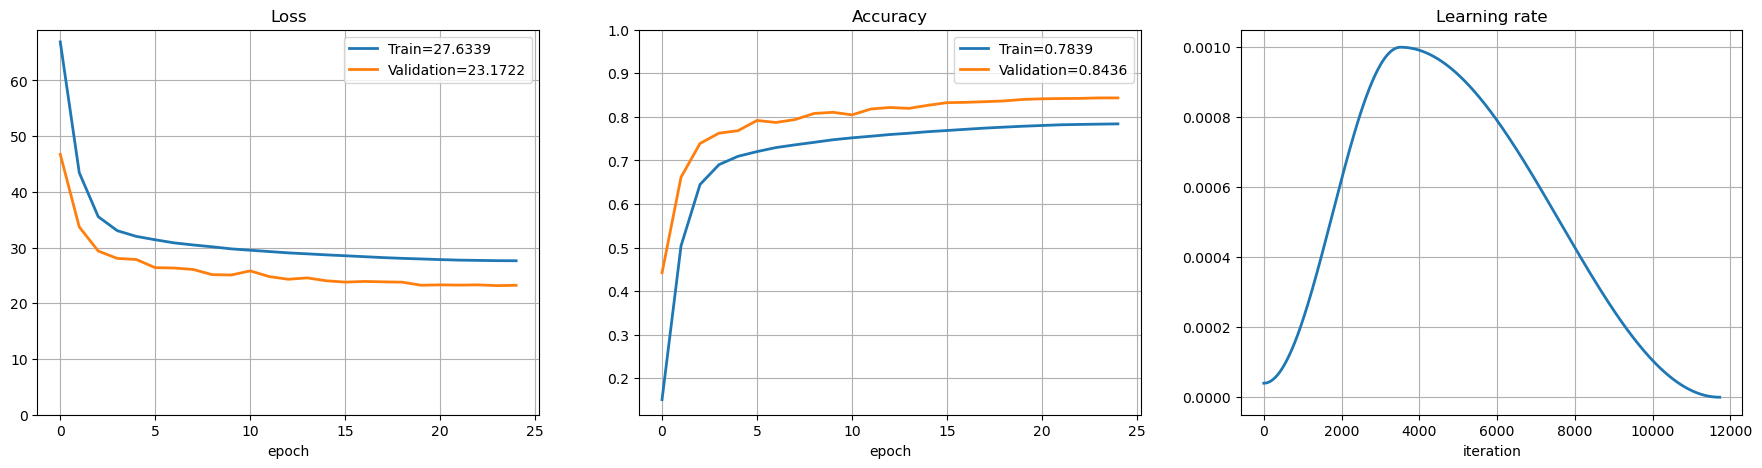

In [21]:
from DeepLearningFramework.Auxiliary import PlotHistory

PlotHistory(lHistory)
plt.show   ()

#### Test reconstruction:

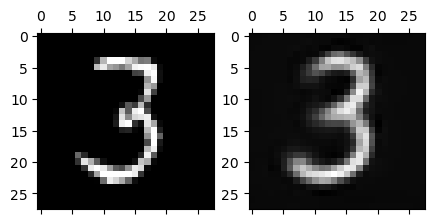

In [22]:
idx   = np.random.randint(len(oTestSet))
mX, _ = oTestSet[idx]

with torch.no_grad():
    mHatX = oModel(mX[None,...].to(DEVICE))[0][0]

_, ax = plt.subplots(1, 2, figsize=(5, 3))
ax[0].matshow(mX   [0],       cmap='gray')
ax[1].matshow(mHatX[0].cpu(), cmap='gray')
plt.show()

### Generate new samples:

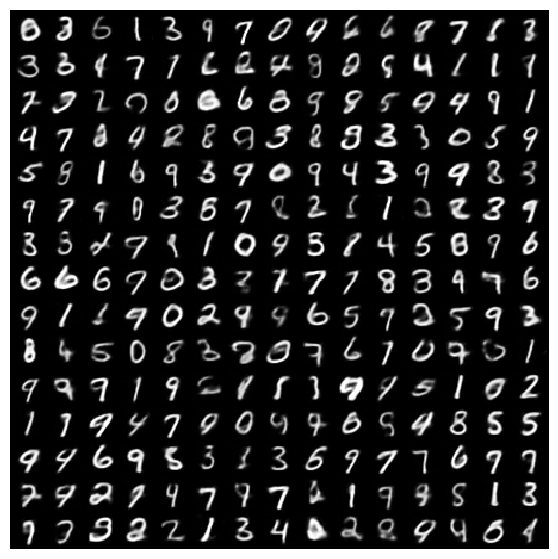

In [23]:
oDecoder = oModel.oDecoder
oDecoder.to(DEVICE)

mZ = torch.randn(15**2, D)
with torch.no_grad():
    mNewX = oDecoder(mZ.to(DEVICE)).squeeze(0).cpu()

mG = torchvision.utils.make_grid(mNewX, nrow=15)
mG = torch.clamp(mG.permute(1,2,0), 0, 1)

_, ax = plt.subplots(figsize=(7, 7))
ax.matshow(mG, cmap='gray')
ax.axis   ('off')
plt.show  ()

### Interpolate between images:

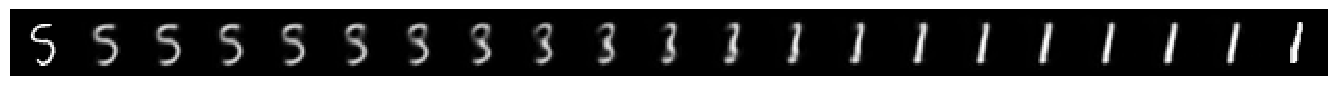

In [52]:
nTrain     = len(oTrainSet)
idx1, idx2 = np.random.randint(0, nTrain, (2,))

mX1, _     = oTrainSet[idx1]
mX2, _     = oTrainSet[idx2]

oEncoder   = oModel.oEncoder
with torch.no_grad():
    vZ1 = oEncoder(mX1[None,...].to(DEVICE))[0]
    vZ2 = oEncoder(mX2[None,...].to(DEVICE))[0]
    
K  = 19
v  = torch.linspace(0, 1, K)[:,None].to(DEVICE)
mZ = v * vZ2 + (1 - v) * vZ1
with torch.no_grad():
    mHatX = oModel.oDecoder(mZ).cpu()
    
mHatX = torch.cat([mX1[None,...], mHatX, mX2[None,...]], dim=0)
mG    = torchvision.utils.make_grid(mHatX, nrow=K+2)
mG    = torch.clamp(mG.permute(1,2,0), 0, 1)

_, ax = plt.subplots(figsize=(17, 2))
ax.matshow(mG, cmap='gray')
ax.axis   ('off')
plt.show  ()